In [1]:
import operator
from progressbar import progressbar
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix, coo_matrix, csr_matrix
import matplotlib.pyplot as plt

In [2]:
def cost(X, Theta, Y, R, lambda_):
    J = ((X@Theta.T - Y).multiply(R).power(2).sum() / 2
         + lambda_ / 2 * X.power(2).sum()
         + lambda_ / 2 * Theta.power(2).sum())
    return J


def gradient(X, Theta, Y, R):
    X_grad = lil_matrix((X.shape[0], X.shape[1]))
    Theta_grad = lil_matrix((Theta.shape[0], Theta.shape[1]))
    for i in range(X_grad.shape[0]):
        idx = (R[i, :] == 1).nonzero()[1]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = ((X[i, :]@Theta_temp.transpose() - Y_temp) @ Theta_temp
                        # 1 x n          n x k            1 x k       k x n 
                        + lambda_ * X[i, :])
    for j in range(Theta_grad.shape[0]):
        idx = (R[:, j] == 1).nonzero()[1]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = ((Theta[j, :]@X_temp.transpose() - Y_temp.transpose()) @ X_temp
                            #   1 x n          n x k                1 x k           k x n
                            + lambda_ * Theta[j, :])
    return X_grad.tocsr(), Theta_grad.tocsr()


def gradient_descent(X, Theta, Y, R, alpha, n_iter, lambda_):
    J_history = []
    for _ in progressbar(range(n_iter)):
        X_grad, Theta_grad = gradient(X, Theta, Y, R)
        X = X - alpha * X_grad
        Theta = Theta - alpha * Theta_grad
        J = cost(X, Theta, Y, R, lambda_)
        J_history.append(J)
    return X, Theta, J_history

In [3]:
# Load data
movies = pd.read_csv('./data/ml-latest-small/movies.csv', header=0, names=['movie', 'title', 'genres'])
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv', header=0, names=['user', 'movie', 'rating', 'timestamp'])

# To speed up, keep only movies with more than 50 ratings
n_ratings = ratings.groupby('movie')['user'].count()
most_rated = n_ratings[n_ratings >= 50].index.tolist()
movies = movies[movies['movie'].isin(most_rated)].reset_index(drop=True)
ratings = ratings[ratings['movie'].isin(most_rated)]
n_movies = len(movies)
n_users = ratings['user'].nunique() + 1
print('Number of movies:', n_movies)
print('Number of users:', n_users)

# Reindex movies to have consecutive ids
movie_dict = movies['movie'].reset_index().set_index('movie').to_dict()['index']
movies['movie'] = movies['movie'].map(movie_dict)
ratings['movie'] = ratings['movie'].map(movie_dict)

# Reindex users to have consecutive ids
user_dict = (pd.Series(ratings['user'].unique(), index=range(1, n_users), name='user')
             .reset_index().set_index('user').to_dict()['index'])
ratings['user'] = ratings['user'].map(user_dict)

# Construct sparse matrix Y
row = ratings['movie'].values
col = ratings['user'].values
data = ratings['rating'].values
Y = csr_matrix((data, (row, col)), shape=(n_movies, n_users)).tolil()

# Add ratings to the first column of Y (which was left empty)
my_ratings = {56: 5,
              66: 4,
              109: 3.5,
              138: 3.5,
              201: 3,
              203: 3,
              250: 3,
              252: 4,
              301: 3,
              380: 4.5,
              431: 3.5,
              436: 3.5,
              442: 3,
              443: 3.5,
              450: 3.5,
              452: 3}
for m, r in my_ratings.items():
    Y[m, 0] = r
Y = Y.tocsr()

# Construct binary matrix R
nonzero_row, nonzero_col = Y.nonzero()
n_nonzero = len(nonzero_row)
R = csr_matrix(([1]*n_nonzero, (nonzero_row, nonzero_col)), shape=(Y.shape[0], Y.shape[1]))

# Normalize ratings
Y_mean = np.array([Y[i, Y[i, :].nonzero()[1]].mean() for i in range(Y.shape[0])])
Y = Y.tocoo()
data = Y.data
for i, m in enumerate(Y_mean):
    idx = Y.row == i
    data[idx] -= m
Y = coo_matrix((data, (Y.row, Y.col)), shape=(n_movies, n_users)).tocsr()

Number of movies: 453
Number of users: 671


In [4]:
# Initialize X and Theta
n = 100
np.random.seed(52)
X = csr_matrix(np.random.normal(size=(n_movies, n)))
Theta = csr_matrix(np.random.normal(size=(n_users, n)))

alpha = 6e-5
n_iter = 20
lambda_ = 1e4

# Run gradient descent
X, Theta, J_history = gradient_descent(X, Theta, Y, R, alpha, n_iter, lambda_)

100% (20 of 20) |########################| Elapsed Time: 0:00:43 Time:  0:00:43


### Gradient Descent Convergence Check

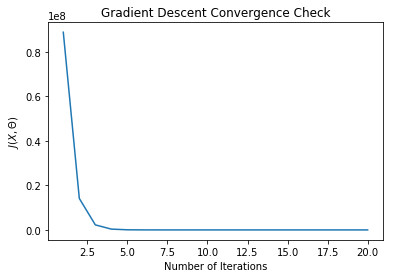

In [5]:
plt.plot(range(1, len(J_history)+1), J_history)
plt.xlabel('Number of Iterations')
plt.ylabel(r'$J(X, \Theta)$')
plt.title('Gradient Descent Convergence Check')
plt.show()

### Recommendations

In [6]:
# Make predictions
pred = X @ Theta.transpose()
my_pred = pred[:, 0].toarray().flatten() + Y_mean

# Get top recommendations
n_rec = 10
while True:
    rec = my_pred.argsort()[-n_rec:][::-1]
    # If recommendations contain movies already seen, remove them and get new recommendations
    rec_seen = set(rec) & set(my_ratings.keys())
    if len(set(rec) - set(rec_seen)) == 10:
        rec = [r for r in rec if r not in rec_seen]
        break
    else:
        n_rec += len(rec_seen)
        continue
rec_ratings = my_pred[rec].round(1)

print('Top recommendations:')
for m, r in zip(rec, rec_ratings):
    print('{:3.1f} {}'.format(r, movies.loc[movies['movie'] == m, 'title'].values[0]))
print()
print('Ratings originally provided:')
for m, r in sorted(my_ratings.items(), key=operator.itemgetter(1))[::-1]:
    print('{:3.1f} {}'.format(r, movies.loc[movies['movie'] == m, 'title'].values[0]))

Top recommendations:
4.5 Godfather, The (1972)
4.4 African Queen, The (1951)
4.4 Maltese Falcon, The (1941)
4.4 Godfather: Part II, The (1974)
4.4 Usual Suspects, The (1995)
4.4 Raging Bull (1980)
4.3 Chinatown (1974)
4.3 Rear Window (1954)
4.3 12 Angry Men (1957)
4.3 Schindler's List (1993)

Ratings originally provided:
5.0 Shawshank Redemption, The (1994)
4.5 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
4.0 Titanic (1997)
4.0 Forrest Gump (1994)
3.5 Avatar (2009)
3.5 Iron Man (2008)
3.5 Prestige, The (2006)
3.5 V for Vendetta (2006)
3.5 Casablanca (1942)
3.5 Beauty and the Beast (1991)
3.0 Inception (2010)
3.0 Dark Knight, The (2008)
3.0 Matrix, The (1999)
3.0 Truman Show, The (1998)
3.0 Back to the Future (1985)
3.0 Groundhog Day (1993)
